In [1]:
import datetime
import json
import os
import sys
import pandas as pd
import numpy as np
import sys
import tensorflow as tf
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import keras


with open('../data/cluster_limits.json') as json_data:
    dict_classe = json.loads(json_data.read())


dataset_file_path = "../data/dados_2014-2022.csv"
dataset = pd.read_csv(dataset_file_path, index_col=0)

dataset_original = dataset.copy()
folder_figures = "../plots/"

columns_Y = ["UpwardUsedSecondaryReserveEnergy", "DownwardUsedSecondaryReserveEnergy"]
columns_Y = ["UpwardUsedSecondaryReserveEnergy"]
alloc_column = ["SecondaryReserveAllocationAUpward"]

y_columns = columns_Y
datetime_col = "datetime"


d = pd.to_datetime(dataset[datetime_col], format="mixed", utc=True)
columns_X = dataset.columns[~dataset.columns.isin(columns_Y)]

mean = [t for f,t in dataset[columns_Y].copy().replace(0, np.nan).mean().items()]


dataset["hour"] = [f.hour for f in d]
dataset["day"] = [f.day for f in d]
dataset["month"] = [f.month for f in d]
dataset["year"] = [f.year for f in d]
dataset["day_of_year"] = [f.timetuple().tm_yday for f in d]
dataset["day_of_week"] = [f.timetuple().tm_wday for f in d]
dataset["week_of_year"] = [f.weekofyear for f in d]



time_cols = ["hour", "day", "month", "year", "day_of_year", "day_of_week", "week_of_year"]
# Make the y the 1st column
dataset = dataset[y_columns+[col for col in dataset.columns if col not in y_columns]]

# make the time columns the last
dataset = dataset[[col for col in dataset.columns if col not in time_cols]+time_cols]


df = dataset.copy()
df.drop("datetime", axis=1, inplace=True)
# Sort DataFrame by DateTime index
df.sort_index(inplace=True)

# Perform imputation
imputer = IterativeImputer(max_iter=10, random_state=0)
df_imputed = imputer.fit_transform(df)

# Convert the result back to a DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=df.columns, index=df.index)
df_imputed["datetime"] = dataset["datetime"]
dataset = df_imputed.copy()
df_imputed = None

2023-09-20 10:37:30.738572: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-20 10:37:30.887615: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-20 10:37:30.888438: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-20 10:37:32.133206: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<Axes: >

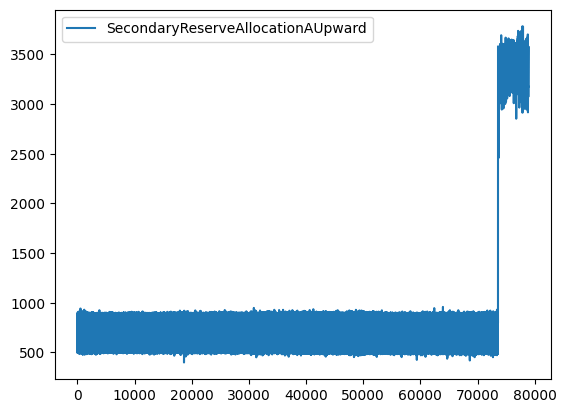

In [2]:
dataset[alloc_column].plot()

<Axes: >

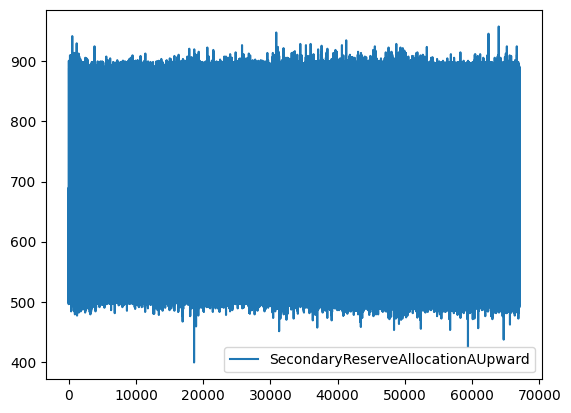

In [3]:
dataset[alloc_column].iloc[:int(len(dataset)*0.85)].plot()

<Axes: >

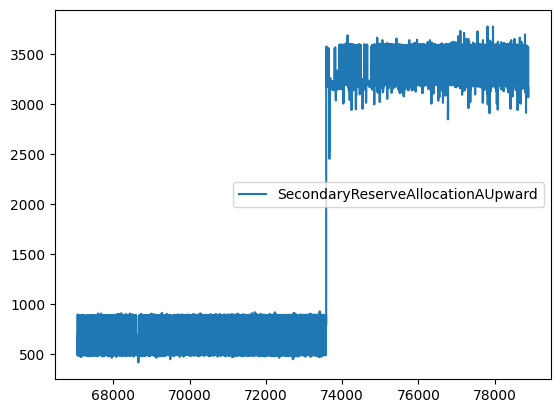

In [4]:
dataset[alloc_column].iloc[len(dataset)-int(len(dataset)*0.15):].plot()

In [5]:
# On this Validation we will only use the  data from 2022
mask_2022 = dataset["year"]==2021


test_dataset = dataset[mask_2022].copy().iloc[:8712]

mask_last_week_2021 = dataset["year"]==2020

week_hours_plus_day = (24*7)

mmm = mask_last_week_2021[mask_last_week_2021].iloc[-week_hours_plus_day:]

mmme = mmm & mask_last_week_2021

mask_data = mmme | mask_2022

dataset = dataset[mask_data]



In [6]:
import pathlib
path_to_trained_models = "../models_trained/"
models_structures = os.listdir(path_to_trained_models)


In [7]:
# Experiment 1 - Architetures and epochs
models_structures = ["linear_models"]

In [8]:
results_df = test_dataset[columns_Y + ["SecondaryReserveAllocationAUpward", "datetime"]].copy()
results_df.reset_index(drop=True, inplace=True)

results_df_label = test_dataset[columns_Y + ["SecondaryReserveAllocationAUpward", "datetime"]].copy()
results_df_label.reset_index(drop=True, inplace=True)

In [9]:
import glob
import importlib
import keras
import tensorflow_decision_forests as tfdf
save_results_folder = "../model_results_2022"





for struct in models_structures:
    #if not "one_model_per_hour_with_classes" in struct:
    #    continue
    strutc_path =  pathlib.Path(os.path.join(pathlib.Path(path_to_trained_models).resolve(), struct))
    list_models =  strutc_path.glob(f'**/*.keras')
    list_models = [f for f in list_models if "freq_saves" not in str(f)]
    
    generator_script =  strutc_path.glob(f'**/*.py')
    generator_script = [f for f in generator_script]
    script = generator_script[0]
    spec = importlib.util.spec_from_file_location("module.name", script)
    module = importlib.util.module_from_spec(spec)

    sys.path.insert(0, os.path.dirname(script)) # Add the script's directory to the system path
    sys.modules[spec.name] = module 
    spec.loader.exec_module(module)

    get_dataset = getattr(module, "get_dataset", None)  # Get the "get_dataset" function from the module
    prepare_for_data = getattr(module, "prepare_for_data", None)  # Get the "get_dataset" function from the module
    prepare_for_model = getattr(module, "prepare_for_model", None)  # Get the "get_dataset" function from the module
    prediction_from_model = getattr(module, "prediction_from_model", None)
    merge_predictions = getattr(module, "merge_predictions", None)
    
    if get_dataset is None:
        print(f"Error: Function 'get_dataset' not found in module {module.__name__}")
        continue
    # Here you can use the get_dataset function. 
    # Don't forget to remove the directory from sys.path if you don't need it anymore.
    sys.path.remove(os.path.dirname(script))


    results_df_label_struct = pd.DataFrame()
    results_df_struct = pd.DataFrame()

    

    for model_path in list_models:

        model_keras = keras.models.load_model(model_path, safe_mode=False,
                                    compile=False)

        
        model_name = os.path.basename(os.path.dirname(os.path.dirname(model_path)))
        model_name = f"{model_name}_{os.path.basename(os.path.dirname(model_path))}"
        model_name = f"{model_name}_{os.path.basename(model_path)}"

        print(model_name)
        if isinstance(model_keras, tfdf.keras.RandomForestModel):
            model_input_shape = None
            model_output_shape = None
            continue

        else:
            model_input_shape = model_keras.input_shape
            model_output_shape = model_keras.output_shape

        extra_args = {}
        data_metadata = prepare_for_data(model_input_shape, model_output_shape)

        X_timeseries = data_metadata["X_timeseries"]
        Y_timeseries = data_metadata["Y_timeseries"]
        frac = 0.85
        train_features_folga = 24
        skiping_step=1
        if "Y_label_dim" in data_metadata:
            y_val = columns_Y[0]
            num_classes = data_metadata["Y_classes"]-1
            key_g = f"{y_val}_{num_classes}"
            dict_classe[key_g][0]=[0]
            extra_args["classes_dict"]=dict_classe[key_g]
        data_to_go = dataset.copy()
        get_dataset_output = get_dataset(
                data_to_go,
                drop_cols=datetime_col,
                y_columns=columns_Y,
                time_moving_window_size_X=X_timeseries,
                time_moving_window_size_Y=Y_timeseries,
                frac=frac,
                keep_y_on_x=True,  # after some intial anlysis keeping the band of the day before helped the models
                train_features_folga=train_features_folga,        
                skiping_step=skiping_step,
                time_cols=time_cols,
                **extra_args,
            )

        X, Y = prepare_for_model(get_dataset_output, model_input_shape, model_output_shape)
        predictions = model_keras.predict(X)
        pred_dict = prediction_from_model(predictions, model_output_shape, model_name, data_metadata)

        
        for key in pred_dict:
            if "label" in key:
                results_df_label_struct[key]=pred_dict[key]
            else:
                results_df_struct[key]=pred_dict[key]
                    
    print("----------------------------------------------")
    if merge_predictions is not None:
        print(len(results_df_struct))
        results_df_label_struct = merge_predictions(results_df_label_struct)
        results_df_struct = merge_predictions(results_df_struct)
    
    results_df = pd.concat([results_df, results_df_struct.iloc[:len(results_df)]], axis=1)
    results_df_label = pd.concat([results_df_label, results_df_label_struct.iloc[:len(results_df_label)]], axis=1)

#results_df.dropna(axis=1, inplace=True)
    

linear_models_VanillaDense_VanillaDense.keras
232/232 [==============================] - 1s 2ms/step
linear_models_StackedCNN_StackedCNN.keras
232/232 [==============================] - 1s 2ms/step
linear_models_UNET_UNET.keras
232/232 [==============================] - 4s 12ms/step
linear_models_VanillaCNN_VanillaCNN.keras
232/232 [==============================] - 1s 2ms/step
----------------------------------------------


In [10]:
results_df.dropna(axis=1, inplace=True)


<Axes: >

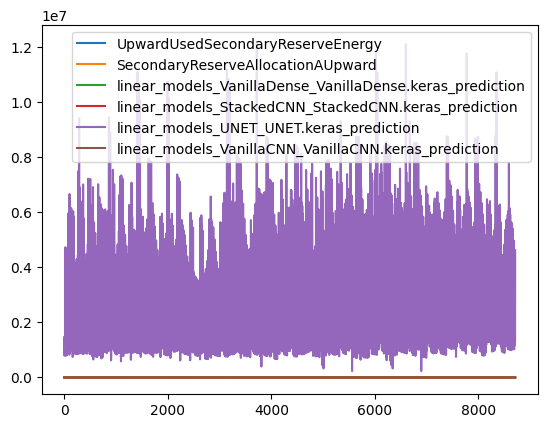

In [11]:
results_df.plot()

In [12]:
results_df

,UpwardUsedSecondaryReserveEnergy,SecondaryReserveAllocationAUpward,datetime,linear_models_VanillaDense_VanillaDense.keras_prediction,linear_models_StackedCNN_StackedCNN.keras_prediction,linear_models_UNET_UNET.keras_prediction,linear_models_VanillaCNN_VanillaCNN.keras_prediction
0,3.5,498.0,2021-01-01 01:00:00+01:00,78.789528,549.593506,9.632974e+05,36.039497
1,0.3,597.0,2021-01-01 02:00:00+01:00,65.876930,464.934967,9.587118e+05,-0.817280
2,3.0,596.0,2021-01-01 03:00:00+01:00,210.622330,422.135162,1.025518e+06,116.068642
3,4.0,489.0,2021-01-01 04:00:00+01:00,73.552864,458.206696,7.957836e+05,184.030334
4,3.5,496.0,2021-01-01 05:00:00+01:00,220.924606,497.550964,1.341417e+06,187.895905
...,...,...,...,...,...,...,...
8707,76.2,499.0,2021-12-29 20:00:00+01:00,249.876007,485.925842,1.555406e+06,78.377670
8708,298.0,594.0,2021-12-29 21:00:00+01:00,250.485306,516.890930,1.277331e+06,101.261757
8709,229.5,598.0,2021-12-29 22:00:00+01:00,262.985504,550.823853,1.359861e+06,157.178085
8710,91.6,598.0,2021-12-29 23:00:00+01:00,304.094940,553.918884,4.289201e+06,221.171066


In [13]:
true_test_col = "UpwardUsedSecondaryReserveEnergy"
alloc_test_col = "SecondaryReserveAllocationAUpward"

pred_cols = [f for f in results_df.columns if f not in [true_test_col, alloc_test_col, "datetime"]]

erro_dict_true = {}
erro_dict_alloc = {}
erro_dict_alloc_comp = {}

for col in pred_cols:
    true_erro = results_df[true_test_col] - results_df[col]
    alloc_erro = np.where(results_df[col] >= results_df[true_test_col], 0, results_df[true_test_col]-results_df[col])
    erro_dict_alloc[col]=alloc_erro

error_alloc_df = pd.DataFrame(erro_dict_alloc)
error_alloc_df["baseline_error"] = np.where(results_df[alloc_test_col] >= results_df[true_test_col], 0, results_df[true_test_col]-results_df[alloc_test_col])

In [14]:
error_alloc_df

,linear_models_VanillaDense_VanillaDense.keras_prediction,linear_models_StackedCNN_StackedCNN.keras_prediction,linear_models_UNET_UNET.keras_prediction,linear_models_VanillaCNN_VanillaCNN.keras_prediction,baseline_error
0,0.000000,0.0,0.0,0.000000,0.0
1,0.000000,0.0,0.0,1.117280,0.0
2,0.000000,0.0,0.0,0.000000,0.0
3,0.000000,0.0,0.0,0.000000,0.0
4,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...
8707,0.000000,0.0,0.0,0.000000,0.0
8708,47.514694,0.0,0.0,196.738243,0.0
8709,0.000000,0.0,0.0,72.321915,0.0
8710,0.000000,0.0,0.0,0.000000,0.0


In [15]:
error_alloc_df

,linear_models_VanillaDense_VanillaDense.keras_prediction,linear_models_StackedCNN_StackedCNN.keras_prediction,linear_models_UNET_UNET.keras_prediction,linear_models_VanillaCNN_VanillaCNN.keras_prediction,baseline_error
0,0.000000,0.0,0.0,0.000000,0.0
1,0.000000,0.0,0.0,1.117280,0.0
2,0.000000,0.0,0.0,0.000000,0.0
3,0.000000,0.0,0.0,0.000000,0.0
4,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...
8707,0.000000,0.0,0.0,0.000000,0.0
8708,47.514694,0.0,0.0,196.738243,0.0
8709,0.000000,0.0,0.0,72.321915,0.0
8710,0.000000,0.0,0.0,0.000000,0.0


<Axes: >

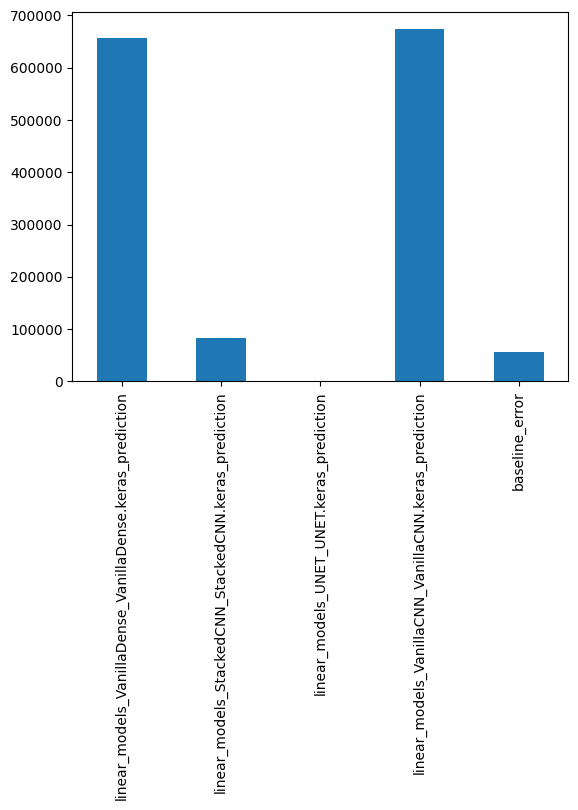

In [16]:
error_alloc_df.sum().plot.bar()

In [17]:
baseline_sum = error_alloc_df['baseline_error'].sum()
better_cols=[]
for column in error_alloc_df.columns:
    if error_alloc_df[column].sum() < baseline_sum:
        better_cols.append(column)
        print(f"The sum of column '{column}' is smaller than the sum of 'baseline_error' column.")


The sum of column 'linear_models_UNET_UNET.keras_prediction' is smaller than the sum of 'baseline_error' column.


<Axes: >

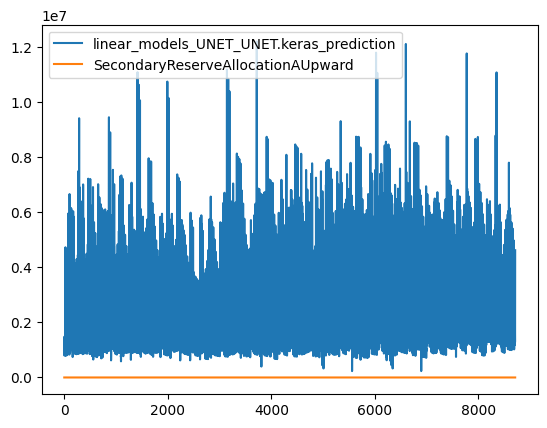

In [18]:
results_df[better_cols+[alloc_test_col]].dropna(axis=1).plot()

<Axes: >

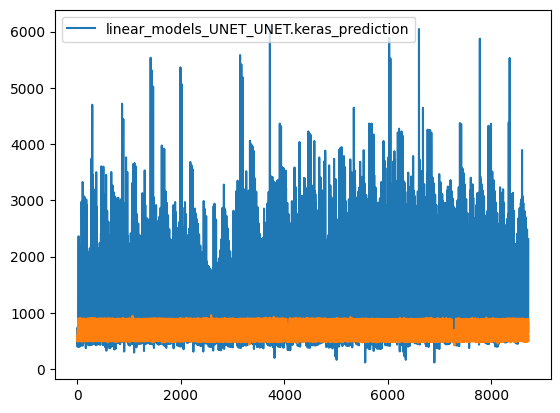

In [30]:
(results_df[better_cols]/20e2).plot()
(results_df[alloc_test_col]).plot()

0       498.0
1       597.0
2       596.0
3       489.0
4       496.0
        ...  
8707    499.0
8708    594.0
8709    598.0
8710    598.0
8711    496.0
Name: SecondaryReserveAllocationAUpward, Length: 8712, dtype: float64

In [25]:
9.632974e+05 /  498.0

1934.3321285140562